# Part I: Define an RL Environment

<b>1. In this part, we will define a grid-world reinforcement learning environment as an MDP. While building an RL environment, you need to define possible states, actions, rewards and other parameters.

In [81]:
import numpy as np
import gym
from gym import Env
import matplotlib.pyplot as plt
import time
import random
import gymnasium as gym
from gym.spaces import Discrete,Box
from gymnasium import spaces
from numpy.lib.polynomial import polyadd
from matplotlib import animation
from matplotlib import pyplot
from matplotlib import colors
import numpy as np
import matplotlib.pyplot as plt
import gym #library for reinforcement problems
from gym import spaces
import time

<b>2. Define an RL environment following the scenario that you chose.</b>

<b>Environment requirements:</b>
    
<b>• Min number of states: 12</b>
    
<b>• Min number of actions: 4</b>
    
<b>• Min number of rewards: 4</b>

In [82]:
class LawnmowerGridWorld:
    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.done = False
        self.rewards = {
            (0, 0): 0,
            (0, 1): 0,
            (0, 2): -5,
            (0, 3): 0,
            (1, 0): 0,
            (1, 1): 0,
            (1, 2): 0,
            (1, 3): -6,
            (2, 0): 0,
            (2, 1): 0,
            (2, 2): 0,
            (2, 3): 0,
            (3, 0): 5,
            (3, 1): 0,
            (3, 2): 6,
            (3, 3): 0
        }
        

    def step(self, action):

        self.state = np.random.choice(self.observation_space.n)
        if action == 0:
            self.agent_pos[0] += 1
        if action == 1:
            self.agent_pos[0] -= 1
        if action == 2:
            self.agent_pos[1] += 1
        if action == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.gold1_pos)] = 0.7
        self.state[tuple(self.gold2_pos)] = 0.7
        self.state[tuple(self.danger1_pos)] = 0.3
        self.state[tuple(self.danger2_pos)] = 0.3
        observation = self.state.flatten()
        
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 20 #Target position: Given max reward if it reaches target
            self.done = True

        elif (self.agent_pos == self.danger1_pos).all():
            reward = -5 #A negative reward -3 if it enters 1st danger position

        elif (self.agent_pos == self.danger2_pos).all():
            reward = -6 #A negative reward of -4 if it enters 2nd danger position

        elif (self.agent_pos == self.gold1_pos).all():
            reward = 5 #A reward of +2 at [1,1]

        elif (self.agent_pos == self.gold2_pos).all():
            reward = 6 #A reward of +5 at [2,2]
        
        return self.agent_pos, reward, self.done

    def reset(self):
        self.done = False
        self.state = np.zeros((4,4))
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]       
        self.danger1_pos = [0,2] #first danger position (-3)
        self.danger2_pos = [1,3] #second danger position (-4)
        self.gold1_pos = [3,0] #First positive reward position (+2)
        self.gold2_pos = [3,2] #Second positive reward position (+5)

        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.8
        self.state[tuple(self.gold1_pos)] = 0.7
        self.state[tuple(self.gold2_pos)] = 0.7
        self.state[tuple(self.danger1_pos)] = 0.3
        self.state[tuple(self.danger2_pos)] = 0.3
        observation = self.state.flatten()
        return observation

    def render(self, cum_reward):
        # Visualize the environment
        img = np.zeros((4,4,3))
        img[:,:,0] = self.observation_space == 0
        img[:,:,1] = self.observation_space == 5
        img[:,:,2] = self.observation_space == 6
        # Show the agent position
        img[self.agent_pos[0], self.agent_pos[1]] = [0.3, 0, 0]
        # Show the goal position
        img[self.goal_pos[0], self.goal_pos[1]] = [1,1,1]
        # Show the battery positions
        for pos in [(3, 0), (3, 2)]:
            img[pos[0], pos[1]] = [0, 1, 0]
        # Show the rock positions
        for pos in [(0, 2), (1, 3)]:
            img[pos[0], pos[1]] = [0.5, 0.5, 0.5]
        plt.imshow(img, interpolation='none')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"Reward: {cum_reward}")

<b>3. Run a random agent for at least 10 timesteps to show that the environment logic is defined correctly. Print the current state, chosen action, reward and return your grid world visualization for each step.

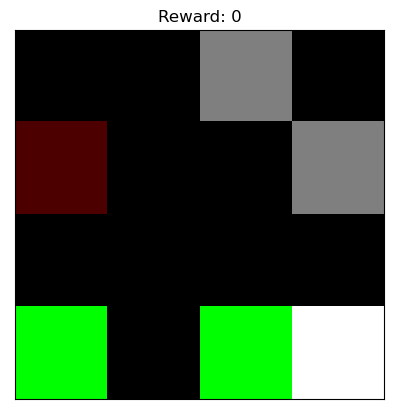

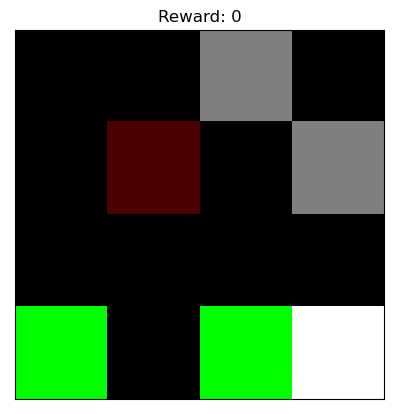

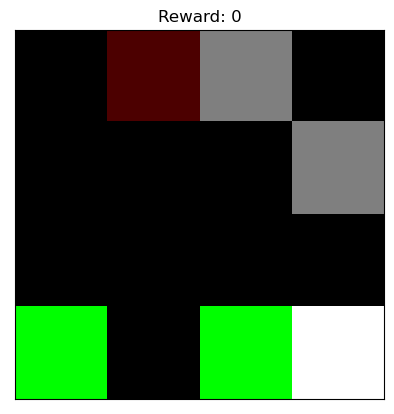

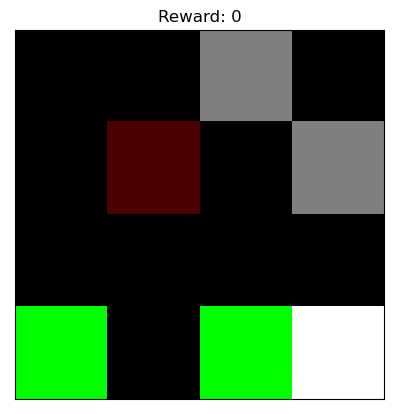

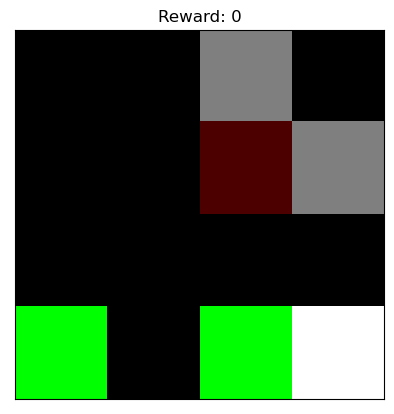

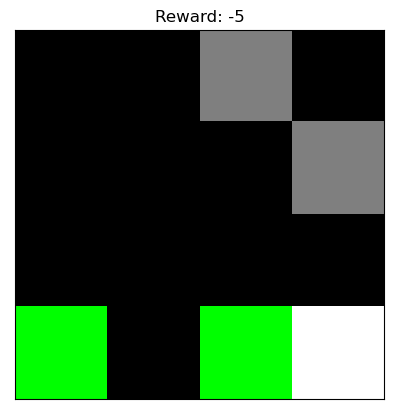

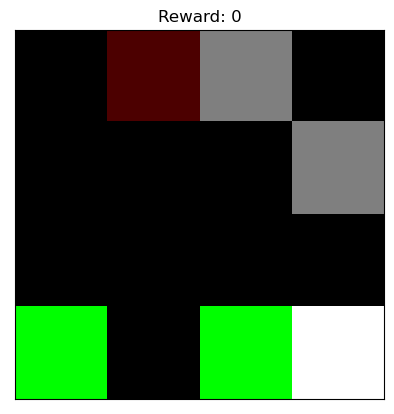

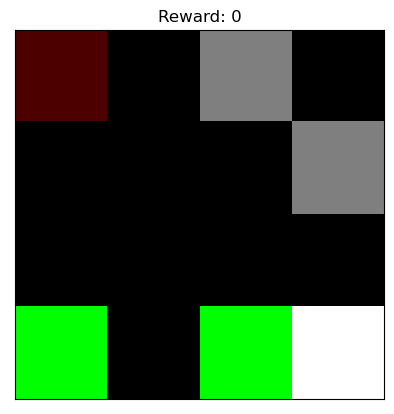

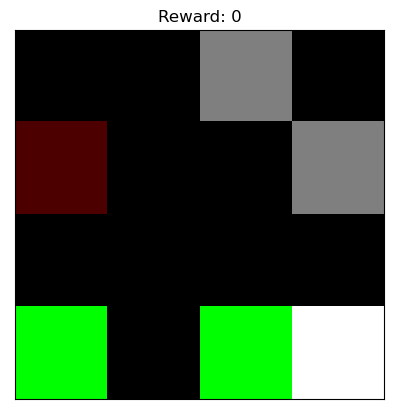

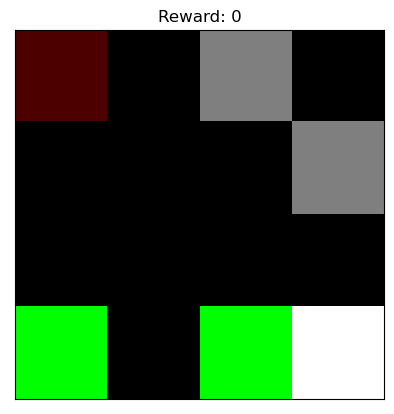

In [83]:
import matplotlib.pyplot as plt

env = LawnmowerGridWorld()
state = env.reset()
for t in range(10):
    action = np.random.choice(env.action_space.n)
    next_state, reward, done = env.step(action)
    env.render(reward)
    plt.show()


# Report for Part I:

<b>Provide visualization of your environment.

<b>Black Grid: Agent
    
<b>Grey Grid: Negative Rewards
    
<b>Green Grid: Positive Rewards
    
<b>White Grid: Goal

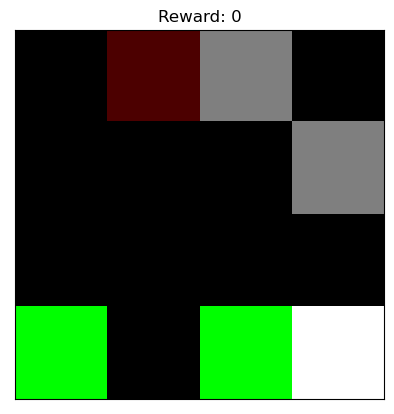

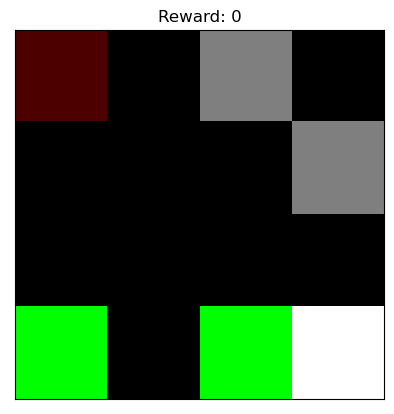

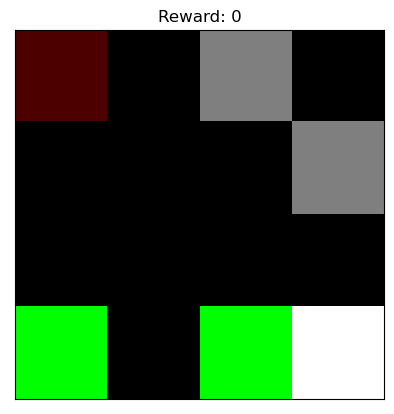

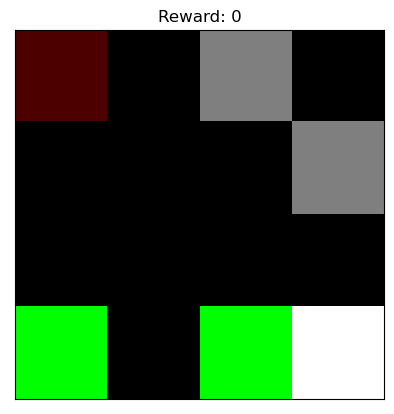

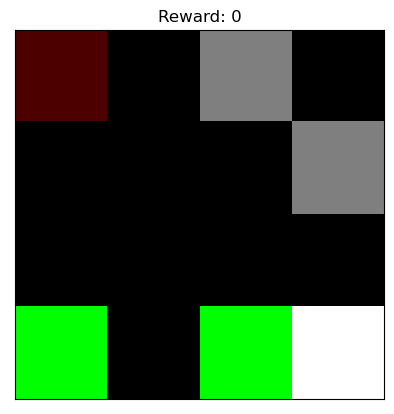

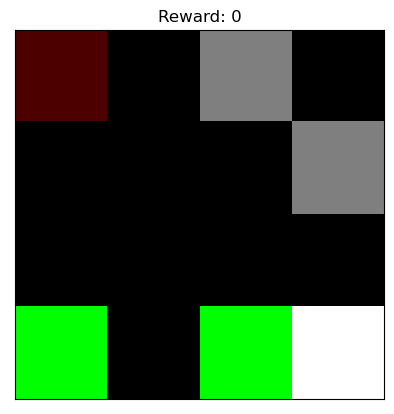

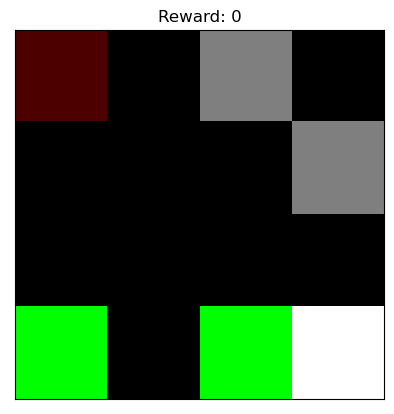

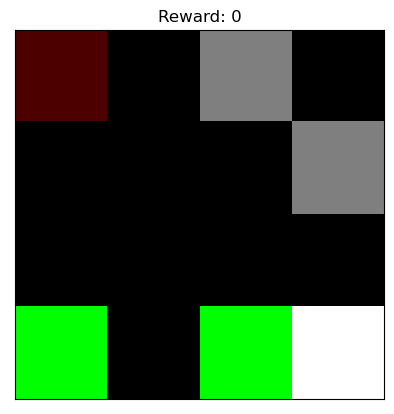

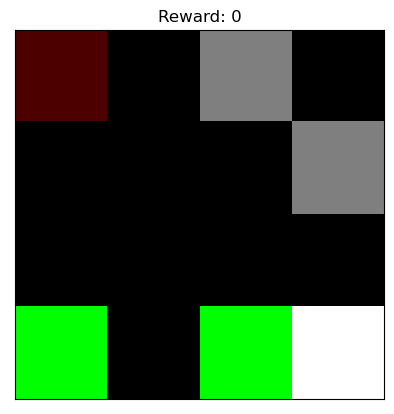

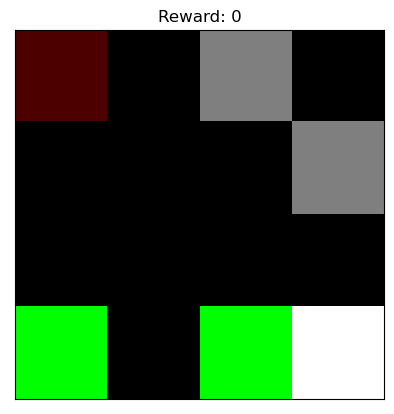

In [84]:
import matplotlib.pyplot as plt

env = LawnmowerGridWorld()
state = env.reset()
for t in range(10):
    action = np.random.choice(env.action_space.n)
    next_state, reward, done = env.step(action)
    env.render(reward)
    plt.show()


# Part II: Solve your environment using – SARSA

In this part, we implement SARSA (State-Action-Reward-State-Action) algorithm and apply it to solve the env defined in Part 1. SARSA is an on-policy reinforcement learning algorithm. The agent updates its Q-values based on the current state, action, reward, and next state, action pair. It uses an exploration-exploitation strategy to balance between exploring new actions and exploiting the knowledge gained so far.

<b>1. Apply SARSA algorithm to solve the environment that was defined in Part I.<b>

In [85]:
def sarsa(discount_factor,timesteps,episodes,lr,ep,evaluation_results):
    env = LawnmowerGridWorld()
    obs = env.reset()
    learning_rate = lr #alpha
    discount_factor = discount_factor #how much weightage to put on future rewards
    det_epsilon = ep #Either action taken or No action taken

    current_state = 0
    action_val = [0,1,2,3]

    q_table = np.zeros((16,4))

    #mapping next_state co-ordinates to q_table co-ordinates
    states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

    optimal = []
    reward_values = []
    total_timesteps = []
    epsilon_values = []
    eva_rewards = []
    aveg_rewards = []


    done = False #signifies if agent reached terminal or not 
    total_episodes = episodes
    eva_episodes = 10
    avg_timesteps = 0
    epsilon = 1
    decay_factor = (0.01/1)**(1/total_episodes)
    target = np.array([3,3])

    #For evaluation results
    if evaluation_results: 
       total_episodes += eva_episodes 
       print("Evaluation Results")

    for episode in range(1, total_episodes+1):
    
      obs = env.reset()
      current_state = 0 
      total_rewards = 0
      timestep = 0


      rand_num = np.random.random()
      if epsilon > rand_num:
        action = np.random.choice(action_val)
      else:
        action = np.argmax(q_table[current_state]) 

      while timestep < timesteps: 
    
        rand_num = np.random.random()
        if det_epsilon > rand_num:
          
            next_state_pos, reward, done = env.step(action)
            next_state = states[tuple(next_state_pos)]

            if np.linalg.norm(target - np.array(next_state_pos)) <= 1:
              reward = reward

            #e - greedy algorithm to choose next_action for next_state
            rand_num = np.random.random()
            if epsilon > rand_num:
              next_action = np.random.choice(action_val)
            else:
              next_action = np.argmax(q_table[next_state]) #action in next state s' with max_q value
          
            #q-value update function for SARSA
            #q_table[current_state][action] = q_table[current_state][action] + learning_rate*(reward + discount_factor*q_table[next_state][next_action] - q_table[current_state][action])
            # SARSA Q-value update
            q_table[current_state][action] += learning_rate * (reward +
                                                               discount_factor * q_table[next_state][next_action] -
                                                               q_table[current_state][action])

            if episode == total_episodes:
              optimal.append(current_state+1)

            total_rewards += reward #Captured all the rewards in each episode
            timestep += 1 #Number of timesteps in each episode

            current_state = next_state #next_state is assigned to current_state
            action = next_action
          
            if done == True: #If terminal or target state reached then stop the episode
              done = False
              break        
          
    
      #Results after each episode
      avg_timesteps += timestep #Capturing all timesteps for all 100 episodes
      total_timesteps.append(avg_timesteps)

      reward_values.append(total_rewards) #Append rewards in every episode
      epsilon_values.append(epsilon) #Append epsilon values in every episode


      if epsilon > 0.01: 
          epsilon = epsilon*decay_factor
      else:
          epsilon = 0.01


      if (episode % 100) == 0 and evaluation_results == False: #printing results for every 100 episodes
        print("Episode: {}, Rewards: {}, Average timesteps taken: {}, epsilon: {}".format(episode, total_rewards, avg_timesteps//100, epsilon))
        avg_timesteps = 0
      aveg_rewards.append(total_rewards)
     
      #printing the optimal path in last episode
      if episode == total_episodes:
            print("Optimal Path: ")
            for i in optimal:
              print(i,"->", end = " ")
            print(next_state+1)

    x = [episode for episode in range(total_episodes)]
    yr = reward_values
    ye = epsilon_values

    yr_eva = eva_rewards
    x_eva = [episode for episode in range(eva_episodes)]
 

    if evaluation_results:
        #episodes vs rewards
        plt.plot(x_eva, yr_eva)
        plt.title("Rewards per episode")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')

    else:
        #episodes vs epsilon
        #Plots showing episodes vs epsilon, episodes vs rewards
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
        ax1.plot(x, ye)
        ax1.set_title("Epsilon decay")

        #episodes vs rewards
        ax2.plot(x,yr)
        ax2.set_title("Rewards per episode")
        
    return total_rewards


Episode: 100, Rewards: 35, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 60, Average timesteps taken: 14, epsilon: 0.39810717055349926
Episode: 300, Rewards: 45, Average timesteps taken: 14, epsilon: 0.2511886431509601
Episode: 400, Rewards: 55, Average timesteps taken: 14, epsilon: 0.15848931924611304
Episode: 500, Rewards: 60, Average timesteps taken: 15, epsilon: 0.1000000000000013
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 14, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 14, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 60, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 epi

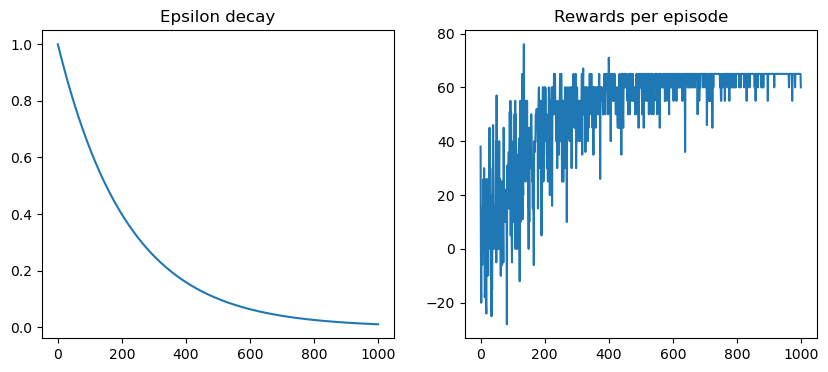

In [86]:
aveg_rewards = sarsa(discount_factor = 0.95, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

<b>2. Try hyperparameter tuning on at least two parameters to get better results for SARSA. You can explore hyperparameter tuning libraries, e.g. Optuna or make it manually. 

<b>Parameters to tune:<br>
<b>a. Discount factor (γ)<br>
<b>b. Epsilon decay rate<br>
<b>c. Epsilon min/max values<br>
<b>d. Number of episodes<br>
<b>e. Max timesteps<br>

<b>Try at least 3 different values for each of the parameters that you choose.

<b>3. Provide the reward graphs and your explanation for each result. In total, you should have at least 3 graphs and your explanations. Make your suggestion
on the most efficient hyperparameters values for your problem setup

<b>Parameter Tuning 1: Discount factor

Episode: 100, Rewards: -6, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 55, Average timesteps taken: 13, epsilon: 0.39810717055349926
Episode: 300, Rewards: 40, Average timesteps taken: 13, epsilon: 0.2511886431509601
Episode: 400, Rewards: 60, Average timesteps taken: 13, epsilon: 0.15848931924611304
Episode: 500, Rewards: 65, Average timesteps taken: 13, epsilon: 0.1000000000000013
Episode: 600, Rewards: 65, Average timesteps taken: 13, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 14, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 ep

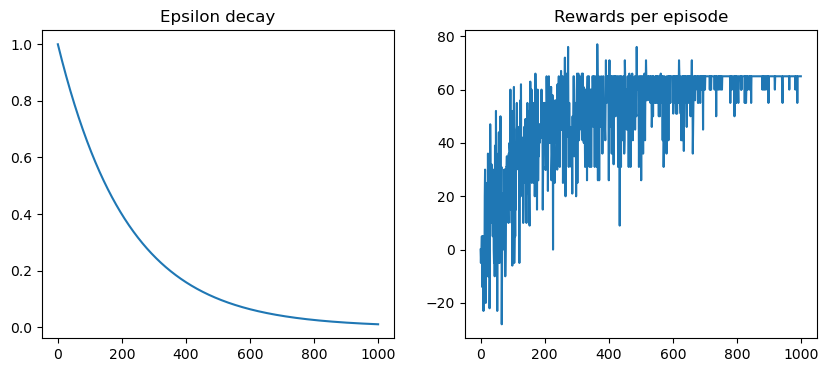

In [87]:
aveg_rewards = sarsa(discount_factor = 0.85, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 57, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 50, Average timesteps taken: 14, epsilon: 0.39810717055349926
Episode: 300, Rewards: 26, Average timesteps taken: 14, epsilon: 0.2511886431509601
Episode: 400, Rewards: 55, Average timesteps taken: 14, epsilon: 0.15848931924611304
Episode: 500, Rewards: 55, Average timesteps taken: 15, epsilon: 0.1000000000000013
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 55, Average timesteps taken: 15, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 ep

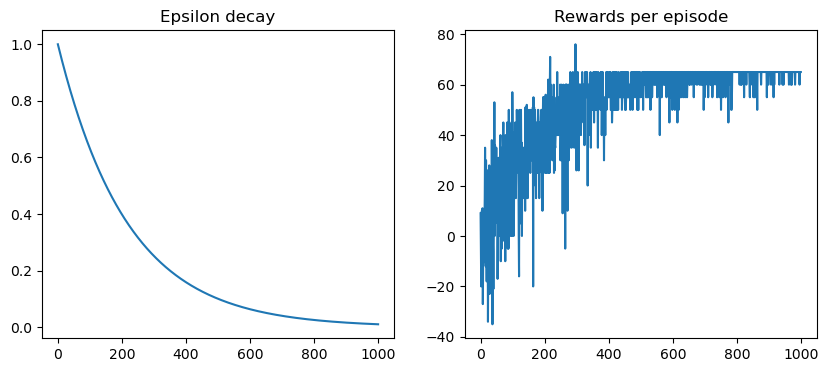

In [88]:
aveg_rewards = sarsa(discount_factor = 0.92, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 18, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 65, Average timesteps taken: 13, epsilon: 0.39810717055349926
Episode: 300, Rewards: 60, Average timesteps taken: 14, epsilon: 0.2511886431509601
Episode: 400, Rewards: 60, Average timesteps taken: 14, epsilon: 0.15848931924611304
Episode: 500, Rewards: 60, Average timesteps taken: 14, epsilon: 0.1000000000000013
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.039810717055350435
Episode: 800, Rewards: 60, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 ep

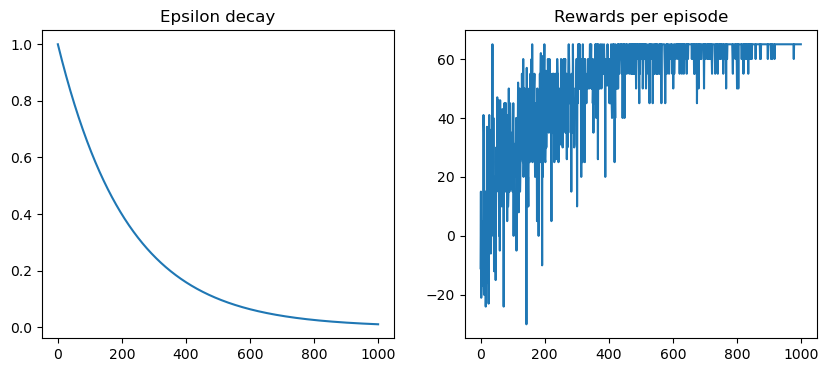

In [89]:
aveg_rewards = sarsa(discount_factor = 0.90, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

<b>Parameter Tuning 2: Number of episodes

Episode: 100, Rewards: 1, Average timesteps taken: 14, epsilon: 0.5623413251903508
Episode: 200, Rewards: 55, Average timesteps taken: 14, epsilon: 0.3162277660168396
Episode: 300, Rewards: 65, Average timesteps taken: 14, epsilon: 0.17782794100389337
Episode: 400, Rewards: 60, Average timesteps taken: 15, epsilon: 0.10000000000000081
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.05623413251903551
Episode: 600, Rewards: 65, Average timesteps taken: 15, epsilon: 0.03162277660168423
Episode: 700, Rewards: 55, Average timesteps taken: 15, epsilon: 0.017782794100389517
Episode: 800, Rewards: 60, Average timesteps taken: 15, epsilon: 0.010000000000000179
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 14 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 800 episodes: 60


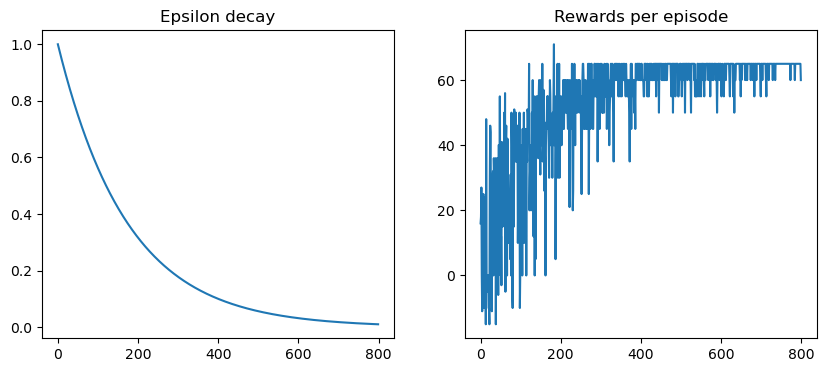

In [90]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 15, episodes = 800, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 800 episodes:", aveg_rewards)

Episode: 100, Rewards: 21, Average timesteps taken: 13, epsilon: 0.6812920690579596
Episode: 200, Rewards: 10, Average timesteps taken: 13, epsilon: 0.4641588833612755
Episode: 300, Rewards: 60, Average timesteps taken: 14, epsilon: 0.3162277660168354
Episode: 400, Rewards: 60, Average timesteps taken: 15, epsilon: 0.215443469003186
Episode: 500, Rewards: 60, Average timesteps taken: 15, epsilon: 0.14677992676220494
Episode: 600, Rewards: 55, Average timesteps taken: 15, epsilon: 0.09999999999999841
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.06812920690579487
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.04641588833612679
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.03162277660168304
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.021544346900318263
Episode: 1100, Rewards: 65, Average timesteps taken: 15, epsilon: 0.014677992676220273
Episode: 1200, Rewards: 65, Average timesteps taken: 15, epsilon: 

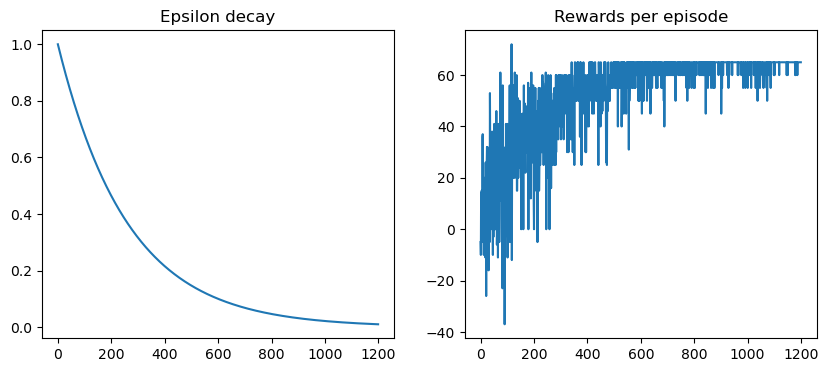

In [91]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 15, episodes = 1200, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1200 episodes:", aveg_rewards)

Episode: 100, Rewards: 26, Average timesteps taken: 14, epsilon: 0.7196856730011542
Episode: 200, Rewards: 30, Average timesteps taken: 13, epsilon: 0.5179474679231238
Episode: 300, Rewards: -3, Average timesteps taken: 14, epsilon: 0.3727593720314971
Episode: 400, Rewards: 37, Average timesteps taken: 14, epsilon: 0.2682695795279756
Episode: 500, Rewards: 60, Average timesteps taken: 15, epsilon: 0.19306977288832766
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.1389495494373161
Episode: 700, Rewards: 55, Average timesteps taken: 15, epsilon: 0.10000000000000195
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.07196856730011685
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.05179474679231345
Episode: 1000, Rewards: 60, Average timesteps taken: 15, epsilon: 0.03727593720315049
Episode: 1100, Rewards: 65, Average timesteps taken: 15, epsilon: 0.026826957952798124
Episode: 1200, Rewards: 65, Average timesteps taken: 15, epsilon: 0

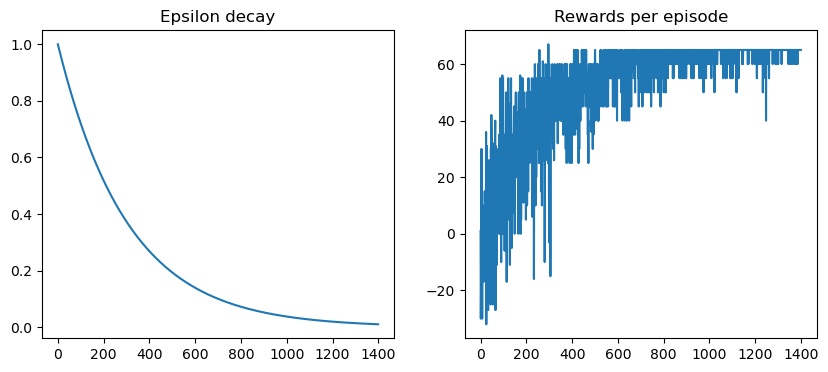

In [92]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 15, episodes = 1400, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1400 episodes:", aveg_rewards)

<b>Parameter Tuning 3: Max timesteps

Episode: 100, Rewards: 0, Average timesteps taken: 9, epsilon: 0.6309573444801949
Episode: 200, Rewards: 15, Average timesteps taken: 9, epsilon: 0.39810717055349926
Episode: 300, Rewards: 25, Average timesteps taken: 9, epsilon: 0.2511886431509601
Episode: 400, Rewards: 40, Average timesteps taken: 10, epsilon: 0.15848931924611304
Episode: 500, Rewards: 35, Average timesteps taken: 10, epsilon: 0.1000000000000013
Episode: 600, Rewards: 40, Average timesteps taken: 10, epsilon: 0.06309573444802027
Episode: 700, Rewards: 40, Average timesteps taken: 10, epsilon: 0.039810717055350435
Episode: 800, Rewards: 40, Average timesteps taken: 10, epsilon: 0.025118864315096318
Episode: 900, Rewards: 40, Average timesteps taken: 10, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 40, Average timesteps taken: 10, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 episodes: 40


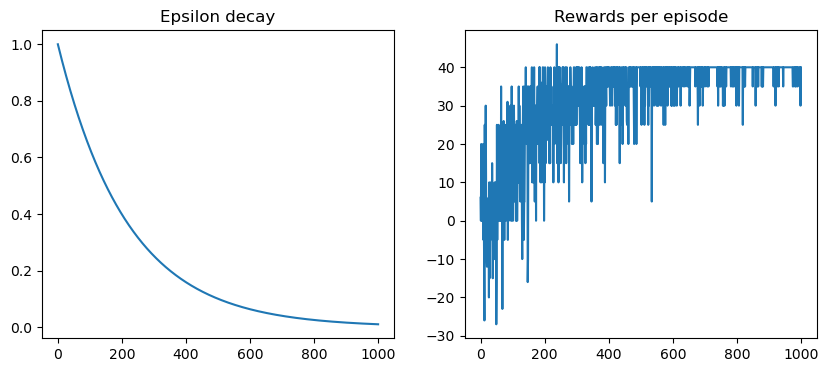

In [93]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 10, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 60, Average timesteps taken: 21, epsilon: 0.6309573444801949
Episode: 200, Rewards: 90, Average timesteps taken: 23, epsilon: 0.39810717055349926
Episode: 300, Rewards: 101, Average timesteps taken: 24, epsilon: 0.2511886431509601
Episode: 400, Rewards: 105, Average timesteps taken: 24, epsilon: 0.15848931924611304
Episode: 500, Rewards: 100, Average timesteps taken: 25, epsilon: 0.1000000000000013
Episode: 600, Rewards: 110, Average timesteps taken: 25, epsilon: 0.06309573444802027
Episode: 700, Rewards: 115, Average timesteps taken: 25, epsilon: 0.039810717055350435
Episode: 800, Rewards: 110, Average timesteps taken: 25, epsilon: 0.025118864315096318
Episode: 900, Rewards: 115, Average timesteps taken: 25, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 115, Average timesteps taken: 25, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 

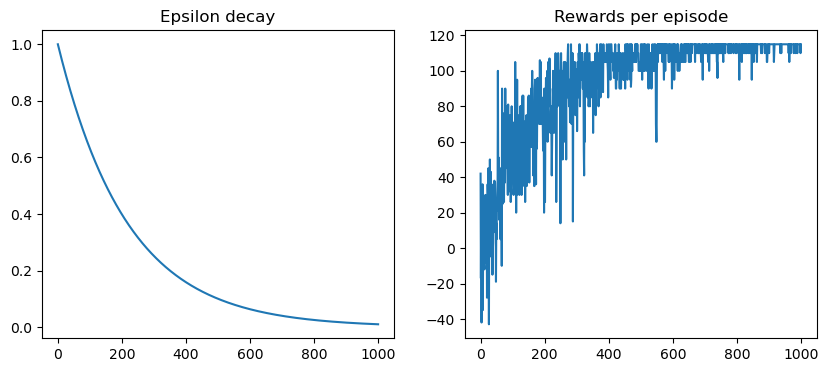

In [94]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 25, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 51, Average timesteps taken: 21, epsilon: 0.6309573444801949
Episode: 200, Rewards: 80, Average timesteps taken: 25, epsilon: 0.39810717055349926
Episode: 300, Rewards: 125, Average timesteps taken: 29, epsilon: 0.2511886431509601
Episode: 400, Rewards: 140, Average timesteps taken: 29, epsilon: 0.15848931924611304
Episode: 500, Rewards: 135, Average timesteps taken: 30, epsilon: 0.1000000000000013
Episode: 600, Rewards: 125, Average timesteps taken: 30, epsilon: 0.06309573444802027
Episode: 700, Rewards: 140, Average timesteps taken: 30, epsilon: 0.039810717055350435
Episode: 800, Rewards: 140, Average timesteps taken: 30, epsilon: 0.025118864315096318
Episode: 900, Rewards: 140, Average timesteps taken: 30, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 140, Average timesteps taken: 30, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 

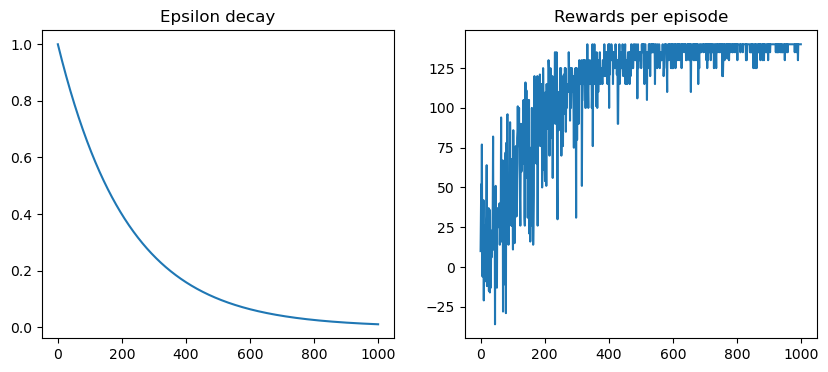

In [95]:
aveg_rewards = sarsa(discount_factor = 0.99, timesteps = 30, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

We tried tuning SARSA Environment with Discount factor(γ), Number of episodes, Max timesteps and we observed below changes:
- As we chnaged Discount factor (γ), we didnt find any significant change in the performance.
- Regarding Number of episodes and Max timesteps, as we increased them we observed increase in rewards and vice-versa so both are directly proportional to rewards.

# Part III: Solve your environment using Q-learning

<B>1. Apply Q-learning algorithm to solve the environment that was defined in Part I. You can modify your code from Part II.<B>

To implement the Q-learning algorithm:

Update the Q-value update rule:

<b>In SARSA, the Q-value update is based on the current action and the next action taken according to the policy.<br>
<b>In Q-learning, the Q-value update is based on the maximum Q-value of the next state-action pairs.<br>

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def Q_learning(discount_factor, timesteps, episodes, lr, ep, evaluation_results):
    env = LawnmowerGridWorld()
    obs = env.reset()
    learning_rate = lr  # alpha
    discount_factor = discount_factor  # how much weightage to put on future rewards
    det_epsilon = ep  # Either action taken or No action taken

    current_state = 0
    action_val = [0, 1, 2, 3]

    q_table = np.zeros((16, 4))

    # mapping next_state co-ordinates to q_table co-ordinates
    states = {(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3,
              (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7,
              (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11,
              (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15}  # 16 states

    optimal = []
    reward_values = []
    total_timesteps = []
    epsilon_values = []
    eva_rewards = []
    aveg_rewards = []

    done = False  # signifies if agent reached terminal or not
    total_episodes = episodes
    eva_episodes = 10
    avg_timesteps = 0
    epsilon = 1
    decay_factor = (0.01 / 1) ** (1 / total_episodes)
    target = np.array([3, 3])

    # For evaluation results
    if evaluation_results:
        total_episodes += eva_episodes
        print("Evaluation Results")

    for episode in range(1, total_episodes + 1):

        obs = env.reset()
        current_state = 0
        total_rewards = 0
        timestep = 0

        rand_num = np.random.random()
        if epsilon > rand_num:
            action = np.random.choice(action_val)
        else:
            action = np.argmax(q_table[current_state])

        while timestep < timesteps:

            rand_num = np.random.random()
            if det_epsilon > rand_num:
                next_state_pos, reward, done = env.step(action)
                next_state = states[tuple(next_state_pos)]

                if np.linalg.norm(target - np.array(next_state_pos)) <= 1:
                    reward = reward

                # e - greedy algorithm to choose next_action for next_state
                rand_num = np.random.random()
                if epsilon > rand_num:
                    next_action = np.random.choice(action_val)
                else:
                    next_action = np.argmax(q_table[next_state])  # action in next state s' with max_q value

                # q-value update function for Q-learning
                max_next_q = np.max(q_table[next_state])  # max Q-value for the next state
                #q_table[current_state][action] = q_table[current_state][action] + learning_rate * (
                 #       reward + discount_factor * max_next_q - q_table[current_state][action])
                
                # Q-learning Q-value update
                q_table[current_state][action] += learning_rate * (reward +
                                                               discount_factor * np.max(q_table[next_state]) -
                                                               q_table[current_state][action])


                if episode == total_episodes:
                    optimal.append(current_state + 1)

                total_rewards += reward  # Captured all the rewards in each episode
                timestep += 1  # Number of timesteps in each episode
                current_state = next_state  # next_state is assigned to current_state
                action = next_action

                if done:
                    break

        # Results after each episode
        avg_timesteps += timestep  # Capturing all timesteps for all episodes
        total_timesteps.append(avg_timesteps)

        reward_values.append(total_rewards)  # Append rewards in every episode
        epsilon_values.append(epsilon)  # Append epsilon values in every episode

        if epsilon > 0.01:
            epsilon *= decay_factor
        else:
            epsilon = 0.01

        if episode % 100 == 0 and not evaluation_results:
            print("Episode: {}, Rewards: {}, Average timesteps taken: {}, epsilon: {}".format(
                episode, total_rewards, avg_timesteps // 100, epsilon))
            avg_timesteps = 0

        aveg_rewards.append(total_rewards)

    x = [episode for episode in range(total_episodes)]
    yr = reward_values
    ye = epsilon_values

    yr_eva = eva_rewards
    x_eva = [episode for episode in range(eva_episodes)]

    if evaluation_results:
        # Episodes vs rewards
        plt.plot(x_eva, yr_eva)
        plt.title("Rewards per episode")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
    else:
        # Episodes vs epsilon
        # Plots showing episodes vs epsilon, episodes vs rewards
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        ax1.plot(x, ye)
        ax1.set_title("Epsilon decay")

        # Episodes vs rewards
        ax2.plot(x, yr)
        ax2.set_title("Rewards per episode")

    #printing the optimal path in last episode
    if episode == total_episodes:
        print("Optimal Path: ")
        for i in optimal:
            print(i,"->", end = " ")
        print(next_state+1)


    return total_rewards


Episode: 100, Rewards: 35, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 55, Average timesteps taken: 14, epsilon: 0.39810717055349926
Episode: 300, Rewards: 60, Average timesteps taken: 15, epsilon: 0.2511886431509601
Episode: 400, Rewards: 65, Average timesteps taken: 14, epsilon: 0.15848931924611304
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.1000000000000013
Episode: 600, Rewards: 50, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 ep

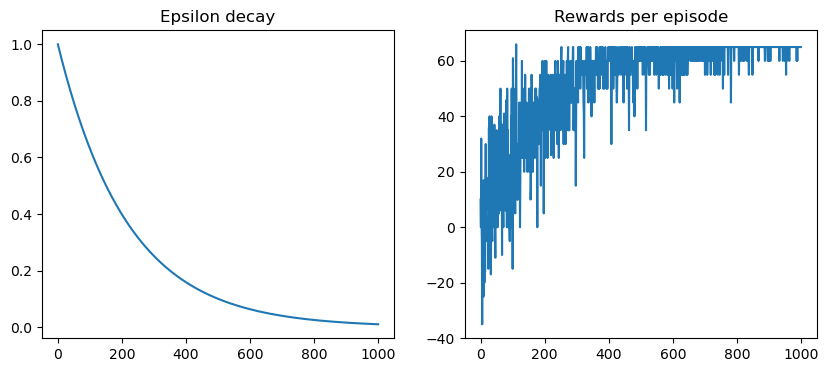

In [97]:
aveg_rewards = Q_learning(discount_factor = 0.95, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

<B>2. Try hyperparameter tuning on at least two parameters to get better results for SARSA. You explore some of the hyperparameter tuning libraries, e.g. Optuna or 
make it manually. Parameters to tune: 
    
<B>f. Discount factor (γ)<br>
<B>g. Epsilon decay rate<br>
<B>h. Epsilon min/max values<br>
<B>i. Number of episodes<br>
<B>j. Max timesteps<br>

<B>Try at least 3 different values for each of the parameters that you choose.<B>

<B>3. Provide the reward graphs and your explanation for each result. In total, you should have at least 3 graphs and your explanations. Make your suggestion on the most efficient hyperparameters values for your problem setup

<b>Parameter Tuning 1: Discount factor

Episode: 100, Rewards: 11, Average timesteps taken: 13, epsilon: 0.6309573444801949
Episode: 200, Rewards: 50, Average timesteps taken: 13, epsilon: 0.39810717055349926
Episode: 300, Rewards: 47, Average timesteps taken: 13, epsilon: 0.2511886431509601
Episode: 400, Rewards: 65, Average timesteps taken: 13, epsilon: 0.15848931924611304
Episode: 500, Rewards: 65, Average timesteps taken: 13, epsilon: 0.1000000000000013
Episode: 600, Rewards: 65, Average timesteps taken: 14, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 14, epsilon: 0.039810717055350435
Episode: 800, Rewards: 71, Average timesteps taken: 14, epsilon: 0.025118864315096318
Episode: 900, Rewards: 71, Average timesteps taken: 14, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 71, Average timesteps taken: 14, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 14 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15 -> 15
   
Average Rewards after completing 1000 ep

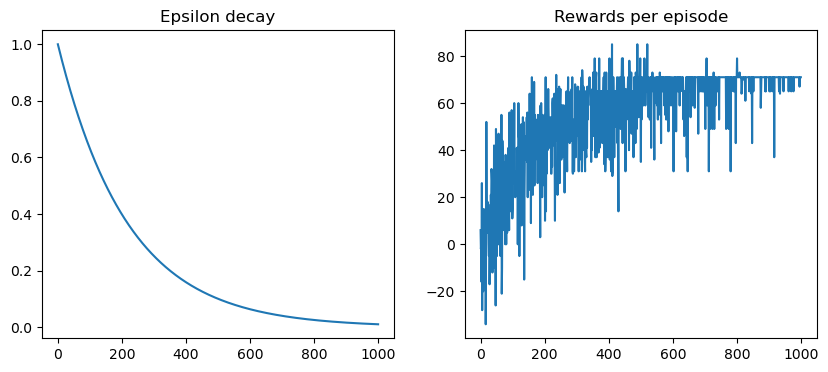

In [98]:
aveg_rewards = Q_learning(discount_factor = 0.85, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 0, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 50, Average timesteps taken: 14, epsilon: 0.39810717055349926
Episode: 300, Rewards: 35, Average timesteps taken: 14, epsilon: 0.2511886431509601
Episode: 400, Rewards: 45, Average timesteps taken: 14, epsilon: 0.15848931924611304
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.1000000000000013
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 epi

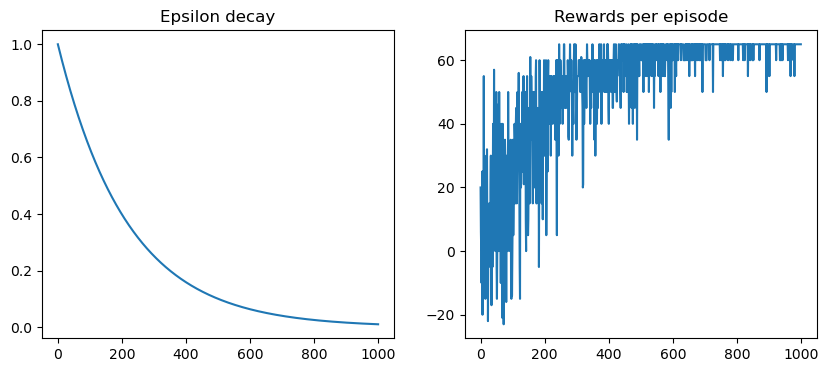

In [99]:
aveg_rewards = Q_learning(discount_factor = 0.92, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 20, Average timesteps taken: 14, epsilon: 0.6309573444801949
Episode: 200, Rewards: 30, Average timesteps taken: 14, epsilon: 0.39810717055349926
Episode: 300, Rewards: 55, Average timesteps taken: 15, epsilon: 0.2511886431509601
Episode: 400, Rewards: 55, Average timesteps taken: 15, epsilon: 0.15848931924611304
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.1000000000000013
Episode: 600, Rewards: 60, Average timesteps taken: 15, epsilon: 0.06309573444802027
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.039810717055350435
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.025118864315096318
Episode: 900, Rewards: 60, Average timesteps taken: 15, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 ep

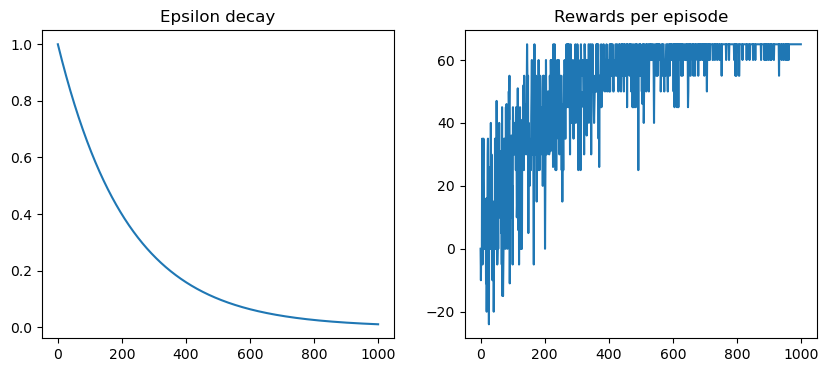

In [100]:
aveg_rewards = Q_learning(discount_factor = 0.90, timesteps = 15, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

<b>Parameter Tuning 2: Number of episodes

Episode: 100, Rewards: -3, Average timesteps taken: 13, epsilon: 0.5623413251903508
Episode: 200, Rewards: 26, Average timesteps taken: 14, epsilon: 0.3162277660168396
Episode: 300, Rewards: 65, Average timesteps taken: 14, epsilon: 0.17782794100389337
Episode: 400, Rewards: 65, Average timesteps taken: 15, epsilon: 0.10000000000000081
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.05623413251903551
Episode: 600, Rewards: 65, Average timesteps taken: 15, epsilon: 0.03162277660168423
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.017782794100389517
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.010000000000000179
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 800 episodes: 65


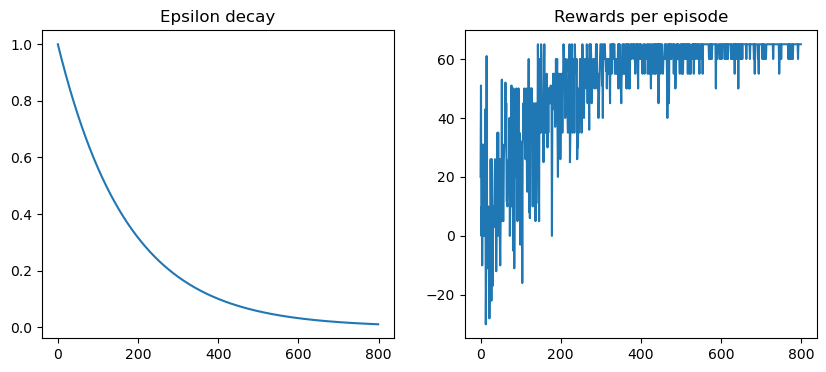

In [101]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 15, episodes = 800, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 800 episodes:", aveg_rewards)

Episode: 100, Rewards: 0, Average timesteps taken: 13, epsilon: 0.6812920690579596
Episode: 200, Rewards: 25, Average timesteps taken: 14, epsilon: 0.4641588833612755
Episode: 300, Rewards: 45, Average timesteps taken: 14, epsilon: 0.3162277660168354
Episode: 400, Rewards: 60, Average timesteps taken: 15, epsilon: 0.215443469003186
Episode: 500, Rewards: 65, Average timesteps taken: 15, epsilon: 0.14677992676220494
Episode: 600, Rewards: 65, Average timesteps taken: 15, epsilon: 0.09999999999999841
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.06812920690579487
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.04641588833612679
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.03162277660168304
Episode: 1000, Rewards: 65, Average timesteps taken: 15, epsilon: 0.021544346900318263
Episode: 1100, Rewards: 65, Average timesteps taken: 15, epsilon: 0.014677992676220273
Episode: 1200, Rewards: 65, Average timesteps taken: 15, epsilon: 0

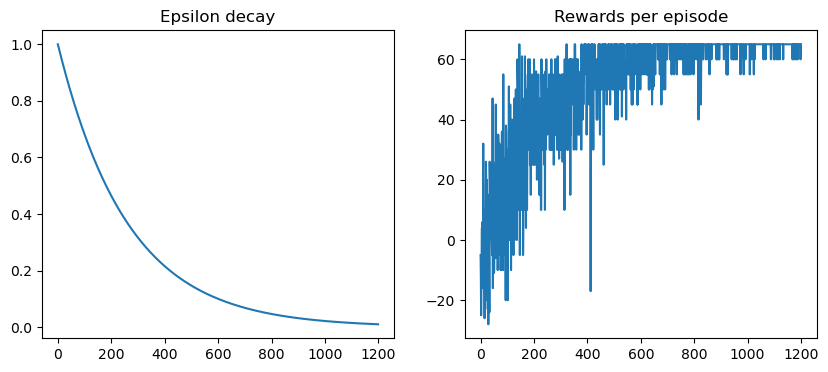

In [102]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 15, episodes = 1200, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1200 episodes:", aveg_rewards)

Episode: 100, Rewards: 26, Average timesteps taken: 14, epsilon: 0.7196856730011542
Episode: 200, Rewards: 40, Average timesteps taken: 14, epsilon: 0.5179474679231238
Episode: 300, Rewards: 35, Average timesteps taken: 14, epsilon: 0.3727593720314971
Episode: 400, Rewards: 40, Average timesteps taken: 14, epsilon: 0.2682695795279756
Episode: 500, Rewards: 60, Average timesteps taken: 15, epsilon: 0.19306977288832766
Episode: 600, Rewards: 55, Average timesteps taken: 15, epsilon: 0.1389495494373161
Episode: 700, Rewards: 65, Average timesteps taken: 15, epsilon: 0.10000000000000195
Episode: 800, Rewards: 65, Average timesteps taken: 15, epsilon: 0.07196856730011685
Episode: 900, Rewards: 65, Average timesteps taken: 15, epsilon: 0.05179474679231345
Episode: 1000, Rewards: 55, Average timesteps taken: 15, epsilon: 0.03727593720315049
Episode: 1100, Rewards: 65, Average timesteps taken: 15, epsilon: 0.026826957952798124
Episode: 1200, Rewards: 65, Average timesteps taken: 15, epsilon: 0

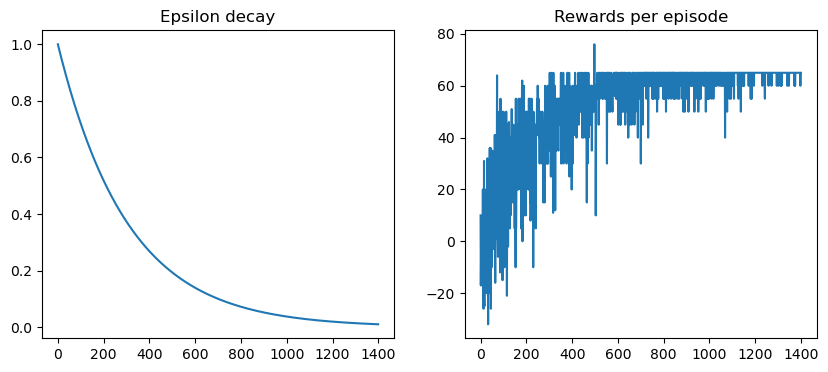

In [103]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 15, episodes = 1400, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1400 episodes:", aveg_rewards)

<b>Parameter Tuning 3: Max timesteps

Episode: 100, Rewards: 25, Average timesteps taken: 9, epsilon: 0.6309573444801949
Episode: 200, Rewards: 15, Average timesteps taken: 9, epsilon: 0.39810717055349926
Episode: 300, Rewards: 30, Average timesteps taken: 9, epsilon: 0.2511886431509601
Episode: 400, Rewards: 35, Average timesteps taken: 9, epsilon: 0.15848931924611304
Episode: 500, Rewards: 35, Average timesteps taken: 10, epsilon: 0.1000000000000013
Episode: 600, Rewards: 40, Average timesteps taken: 10, epsilon: 0.06309573444802027
Episode: 700, Rewards: 40, Average timesteps taken: 10, epsilon: 0.039810717055350435
Episode: 800, Rewards: 40, Average timesteps taken: 10, epsilon: 0.025118864315096318
Episode: 900, Rewards: 40, Average timesteps taken: 10, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 40, Average timesteps taken: 10, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13
   
Average Rewards after completing 1000 episodes: 40


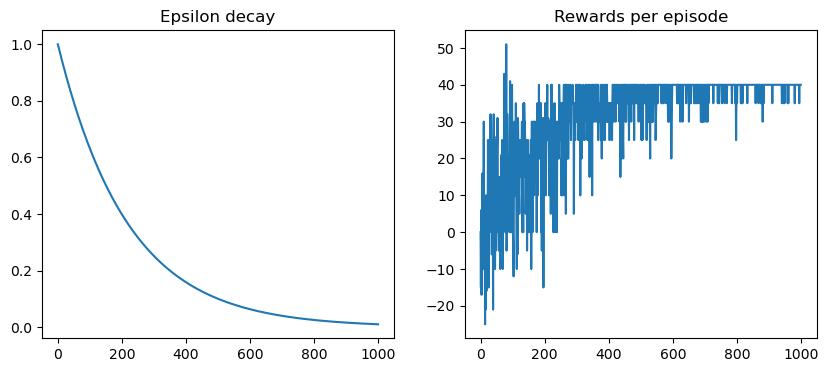

In [104]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 10, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 40, Average timesteps taken: 21, epsilon: 0.6309573444801949
Episode: 200, Rewards: 86, Average timesteps taken: 24, epsilon: 0.39810717055349926
Episode: 300, Rewards: 70, Average timesteps taken: 24, epsilon: 0.2511886431509601
Episode: 400, Rewards: 100, Average timesteps taken: 24, epsilon: 0.15848931924611304
Episode: 500, Rewards: 100, Average timesteps taken: 25, epsilon: 0.1000000000000013
Episode: 600, Rewards: 115, Average timesteps taken: 25, epsilon: 0.06309573444802027
Episode: 700, Rewards: 115, Average timesteps taken: 25, epsilon: 0.039810717055350435
Episode: 800, Rewards: 115, Average timesteps taken: 25, epsilon: 0.025118864315096318
Episode: 900, Rewards: 110, Average timesteps taken: 25, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 115, Average timesteps taken: 25, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -

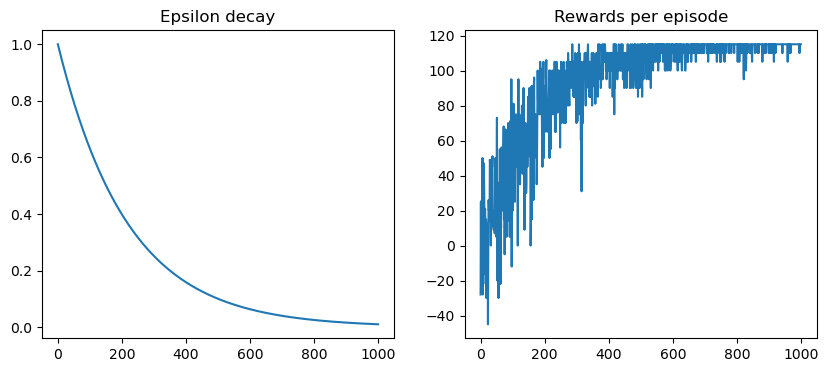

In [105]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 25, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)

Episode: 100, Rewards: 0, Average timesteps taken: 23, epsilon: 0.6309573444801949
Episode: 200, Rewards: 60, Average timesteps taken: 27, epsilon: 0.39810717055349926
Episode: 300, Rewards: 120, Average timesteps taken: 29, epsilon: 0.2511886431509601
Episode: 400, Rewards: 140, Average timesteps taken: 30, epsilon: 0.15848931924611304
Episode: 500, Rewards: 140, Average timesteps taken: 30, epsilon: 0.1000000000000013
Episode: 600, Rewards: 125, Average timesteps taken: 30, epsilon: 0.06309573444802027
Episode: 700, Rewards: 135, Average timesteps taken: 30, epsilon: 0.039810717055350435
Episode: 800, Rewards: 140, Average timesteps taken: 30, epsilon: 0.025118864315096318
Episode: 900, Rewards: 140, Average timesteps taken: 30, epsilon: 0.01584893192461151
Episode: 1000, Rewards: 140, Average timesteps taken: 30, epsilon: 0.010000000000000266
Optimal Path: 
1 -> 5 -> 9 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -> 13 -

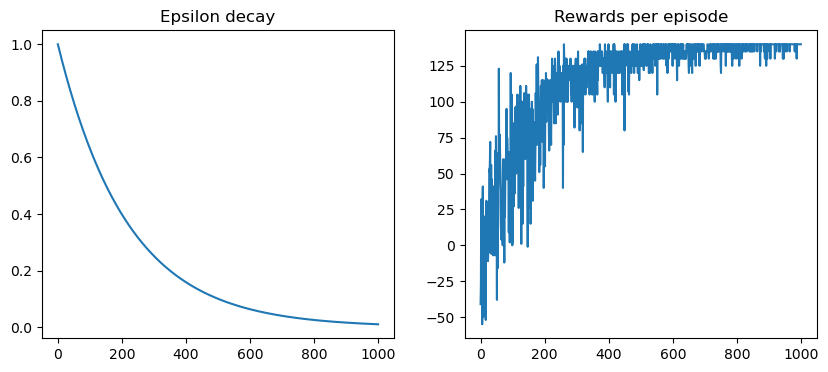

In [106]:
aveg_rewards = Q_learning(discount_factor = 0.99, timesteps = 30, episodes = 1000, lr = 0.15, ep=0.99, evaluation_results = False)
print("   ")
print("Average Rewards after completing 1000 episodes:", aveg_rewards)